# Initialise 

In [7]:
import c14
import c14.livermodels
import datetime
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")

mem = joblib.Memory(cachedir='/scratch/tmp/', verbose=1)

In [8]:
data = pd.read_csv('../../../results/C14data_liver_samples_20190502.csv')
data = data.groupby(['type', 'sample', 'ploidy', 'pathology']).mean().dropna(how='all').reset_index()
data['age'] = data['Dcoll'] - data['Dbirth']
data = data.query('type == "hepatocyte" and pathology != "Y"')
edata = c14.exp_data(data)

In [9]:
@mem.cache
def fit_models(edata, models, step_size=2, optimize_minuit_multistart_kwargs=dict(mode='mcmc',steps=100,nwalkers=100,processes=8)):
    results = {model.__name__: {'model': model()} for model in models}
    for name, result in results.items():
        result['op'] = c14.optimize(model=result['model'],data=edata,step_size=step_size)
        result['vis'] = c14.visualisze(model=result['model'],data=edata)
        result['multistart_result'] = result['op'].optimize_minuit_multistart(**optimize_minuit_multistart_kwargs)
        result['point_estimate'] = result['multistart_result'].sort_values('fval').iloc[0]['values']
        result['cov'] = result['multistart_result'].sort_values('fval').iloc[0]['cov']
        result['errors'] = result['vis'].calc_error(result['point_estimate'], result['cov'])    
    return results

In [28]:
results = fit_models(edata, [c14.livermodels.Pl40, c14.livermodels.Pl40d4], step_size=2, optimize_minuit_multistart_kwargs=dict(mode='mcmc',steps=10,nwalkers=10,processes=8))

________________________________________________________________________________
[Memory] Calling __main__--home-fabrost-pksCloud-projects-C14_liver-source-fabian-python-__ipython-input__.fit_models...
fit_models(<c14.base.exp_data object at 0x7fa35afd9be0>, [<class 'c14.livermodels.Pl40'>, <class 'c14.livermodels.Pl40d4'>], step_size=2, optimize_minuit_multistart_kwargs={'mode': 'mcmc', 'nwalkers': 10, 'processes': 8, 'steps': 10})
7 parameters sets left starting minuit
2 parameters sets left starting minuit
_____________________________________________________fit_models - 131.4s, 2.2min


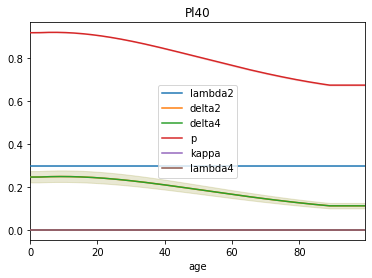

ValueError: operands could not be broadcast together with shapes (200,) (79,) 

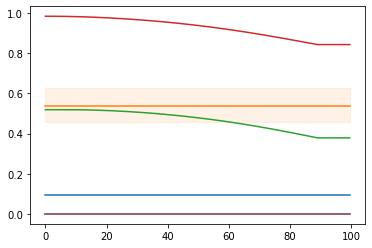

In [30]:
for name, result in results.items():
    result['vis'].plot_parameter(result['point_estimate'], result['errors'])
    plt.legend()
    plt.title(name)
    plt.show()

In [31]:
final_results = pd.DataFrame(pd.Series({name: result['op'].calc_aicc(result['point_estimate']) for name, result in results.items()}, name='cAIC'))
final_results = pd.DataFrame(final_results)
final_results['delta'] = final_results['cAIC'] - final_results['cAIC'].min() 
final_results['w'] = np.exp(-0.5*final_results['delta']) / np.exp(-0.5*final_results['delta']).sum()
final_results['ER'] = final_results['w'].max() / final_results['w']
final_results.sort_values('cAIC')

,cAIC,delta,w,ER
Pl40d4,-180.037503,0.000000,0.693574,1.000000
Pl40,-178.403744,1.633759,0.306426,2.263426
